In [ ]:
from data import load_csv
import os
import csv
import numpy as np

def count_columns(file):
    with open(file, 'r') as f:
        reader = csv.reader(f, delimiter=";")
        header = next(reader)
        has_header = None
        if '.' not in header[0]:
            header = next(reader)
            has_header = 0
        return len(header), header, has_header


def walk_directory(directory, filename):
    total_set = np.empty((0, 2150), float)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, file)
                columns, header, has_header = count_columns(path)
                if columns > 2100 and columns < 4000:
                    try:
                        X_train, _ = load_csv(path, path, x_hdr=has_header, y_hdr=has_header, sep=";")
                        x = X_train[:,0:2150]
                        total_set = np.append(total_set, x, axis=0)
                        print(f"File: {path}, Columns: {columns}", x.shape, f"Total: {total_set.shape}")
                    except:
                        pass

    # arr, uniq_cnt = np.unique(total_set, axis=0, return_counts=True)
    # uniq_total_set = arr[uniq_cnt==1]
    # total_set = np.vstack({tuple(row) for row in total_set})

    np.savetxt(filename, total_set, delimiter=';')
    print(f"Set {filename} saved: {total_set.shape}")


walk_directory('rawdata/2150_set', '2150_dataset.csv') # Replace '.' with the directory path you want to traverse
# walk_directory('rawdata/2150_validation', '2150_validation.csv') # Replace '.' with the directory path you want to traverse

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import re

x_df = pd.read_csv("rawdata/2150_set/Labspec/LabSpecRaw_noid.csv", sep=";", header=0, skip_blank_lines=True)
x_df = x_df.replace(r"^\s*$", np.nan, regex=True).apply(pd.to_numeric, args=("coerce",))

# x_data = x_df.astype(np.float32).values

In [ ]:
x_data = x_df.astype(np.float32).values
x_data = x_data[:,:2150]
np.savetxt("rawdata/2150_set/Labspec/LabSpecRdy.csv", x_data, delimiter=';')

In [2]:
import os
import numpy as np

# data = np.loadtxt(os.path.join('rawdata', '2150_dataset.csv'), delimiter=";")
data = np.loadtxt('2150_dataset.csv', delimiter=";")
data = np.c_[data, np.zeros(len(data)), np.zeros(len(data))]#.astype(np.float16)
if np.isnan(data).any():
    print("ERROR")

data_valid = np.loadtxt('2150_validation.csv', delimiter=";")
data_valid = np.c_[data_valid, np.zeros(len(data_valid)), np.zeros(len(data_valid))]#.astype(np.float16)
if np.isnan(data_valid).any():
    print("ERROR")

print(data.shape, data_valid.shape)

(48335, 2152) (2345, 2152)


In [1]:
import os
import numpy as np

data_valid = np.loadtxt('2150_validation.csv', delimiter=";")
data_valid = np.c_[data_valid, np.zeros(len(data_valid)), np.zeros(len(data_valid))]#.astype(np.float16)
if np.isnan(data_valid).any():
    print("ERROR")

print(data_valid.shape)

(2345, 2152)


In [ ]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

f, t, Sxx = signal.spectrogram(data_valid[0], 0.001, return_onesided=False)
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [3]:
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
tf.keras.mixed_precision.set_global_policy("mixed_float16")

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


def create_model(shape):
    # inputs = tf.keras.layers.Input(shape=shape[1])
    # x = tf.keras.layers.Reshape((shape[1],1))(inputs)
    # x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = tf.keras.layers.MaxPooling1D(2, padding='same')(x)
    # x = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    # x = tf.keras.layers.MaxPooling1D(2, padding='same')(x)
    # x = tf.keras.layers.Conv1D(1, 3, activation='relu', padding='same')(x)
    # x = tf.keras.layers.MaxPooling1D(2, padding='same')(x)
    # encoded = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Reshape((int(shape[1]/8),1))(x)
    # x = tf.keras.layers.Conv1D(1, 3, activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling1D(2)(x)
    # x = tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling1D(2)(x)
    # x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling1D(2)(x)
    # x = tf.keras.layers.Flatten()(x)
    # decoded = tf.keras.layers.Dense(2152, activation='sigmoid')(x)

    ## MLP VERSION
    inputs = tf.keras.layers.Input(shape=shape[1])
    x = tf.keras.layers.GaussianNoise(0.01)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    encoded = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.LayerNormalization()(encoded)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    decoded = tf.keras.layers.Dense(2152, activation='sigmoid')(x)
    

    autoencoder = tf.keras.models.Model(inputs, decoded)
    encoder = tf.keras.models.Model(inputs, encoded)
    return autoencoder, encoder




def train(X_train, X_test, y_train, y_test, machine, epochs=30000):
    autoencoder, encoder = create_model(X_train.shape)#, input_tensor.shape[2]))
    adam = tf.optimizers.Adam(0.01)
    autoencoder.compile(optimizer=adam, loss='mse', metrics='mape')
    autoencoder.summary()
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=500, verbose=1, mode="min", min_delta=0)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=350, min_lr=0.00001, verbose=1)
    model_ckpt = tf.keras.callbacks.ModelCheckpoint(filepath= machine + "_denoiser.hdf5", save_weights_only=True, monitor='val_loss', save_best_only=True)
    autoencoder.fit(X_train, y_train, epochs=epochs, batch_size=20000, shuffle=True, verbose=2, validation_data=(X_test, y_test), callbacks=[early_stop, reduce_lr, model_ckpt])
    return autoencoder, encoder

### source 350-2500
# subrange, machine = np.s_[0:512], "random"
subrange, machine = np.s_[550:1250], "viavi"
# subrange, machine = np.s_[1000:2100], "nirone-sensor-S"
# subrange, machine = np.s_[1200:1600], "nirone-sensor-X"

x_scaler = MinMaxScaler((0.1,0.9))
x_scaler = x_scaler.fit(data.reshape(-1, data.shape[-1]))
data_train = x_scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
data_test = x_scaler.fit_transform(data_valid.reshape(-1, data_valid.shape[-1])).reshape(data_valid.shape)


# X_train, X_test, data_train, data_test = train_test_split(x, data, test_size=0.5, random_state=42, shuffle=False)
# cut = 15000
# X_train, X_test, y_train, y_test = data_train[:cut,:], x[cut:,:], data_train[:cut,:], data[cut:,:]

y_train = data_train
y_test = data_test
X_train = data_train[:, subrange]
X_test = data_test[:, subrange]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
autoencoder, encoder = train(X_train, X_test, y_train, y_test, machine)

(48335, 700) (48335, 2152) (2345, 700) (2345, 2152)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 700)]             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 700)              0         
 se)                                                             
                                                                 
 batch_normalization (BatchN  (None, 700)              2800      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 700)               0         
                                                                 
 dense (Dense)               (None, 512)               358912    
                                                                 
 batch_no

1511/1511 [==============================] - 6s 4ms/step
(2345, 2152) (2345, 2152)
MSE 0.03808933662799123


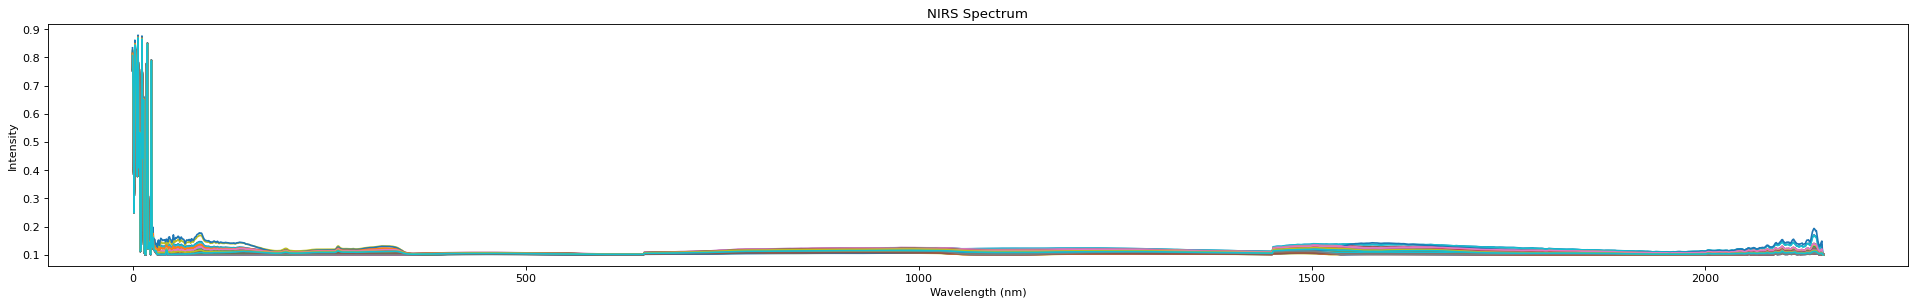

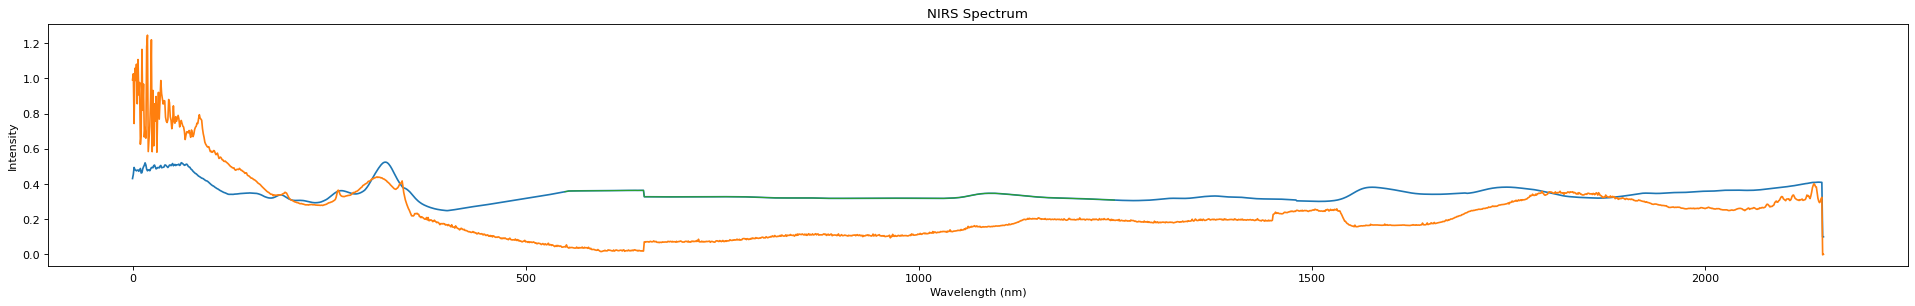

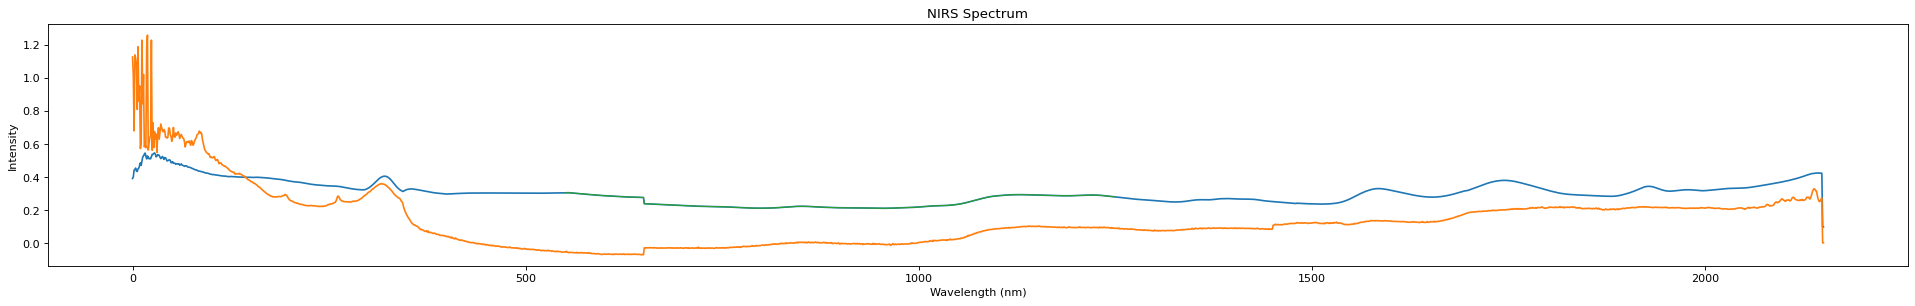

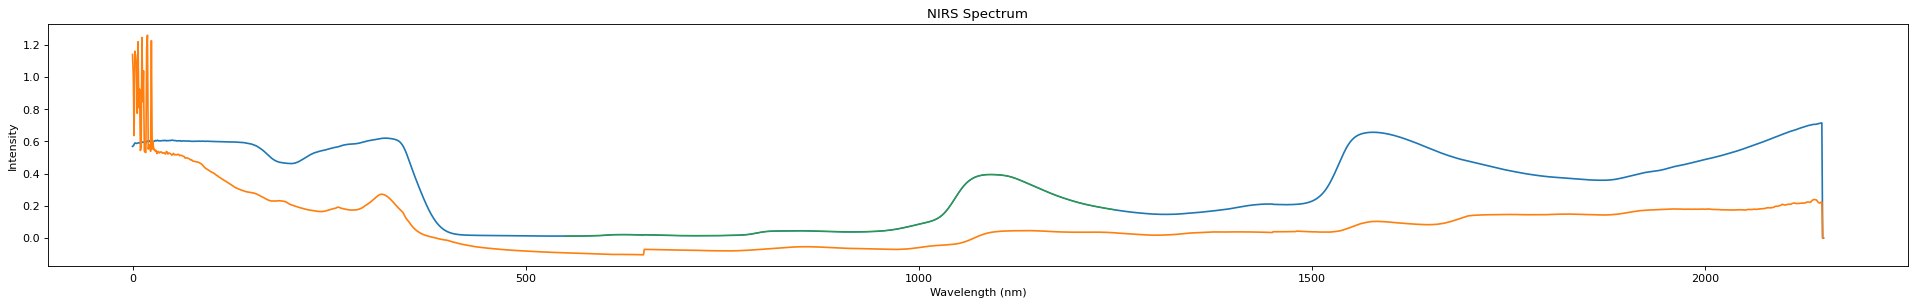

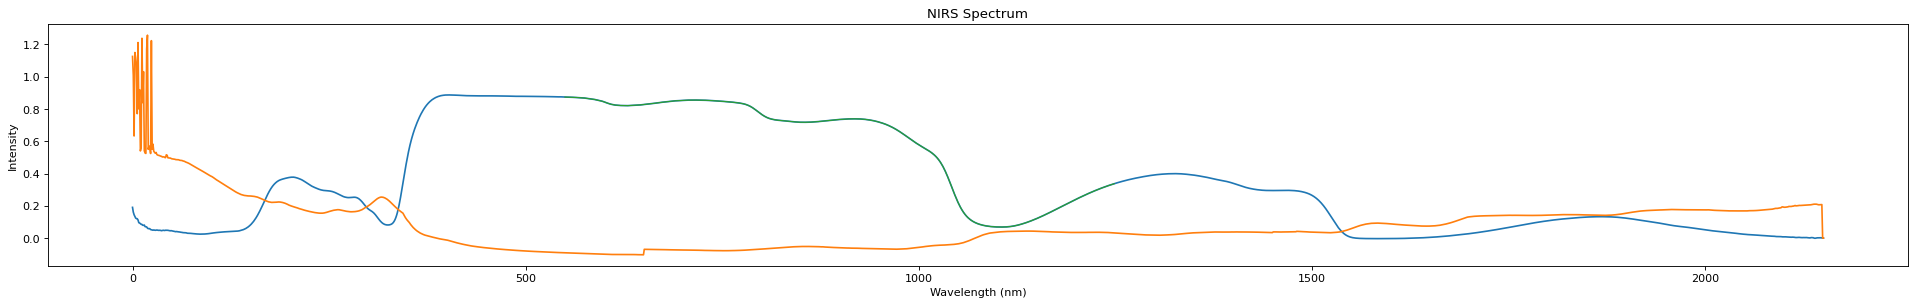

74/74 [==============================] - 0s 3ms/step
[0.0000e+00 0.0000e+00 2.6719e+01 0.0000e+00 0.0000e+00 6.5820e+00
 0.0000e+00 0.0000e+00 0.0000e+00 3.5031e+01 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 6.7500e+01
 9.5391e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.1523e+01 0.0000e+00
 2.1203e+01 0.0000e+00 1.0773e+01 0.0000e+00 4.4188e+01 1.8172e+01
 4.8281e+00 2.5656e+01 0.0000e+00 0.0000e+00 7.2656e-01 0.0000e+00
 4.1289e+00 0.0000e+00 0.0000e+00 3.2000e+01 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 4.8906e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.4766e+01 0.0000e+00 4.0062e+01 0.0000e+00 2.8688e+01
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.1266e+01 0.0000e+00
 1.9094e+01 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 3.7375e+01
 2.2281e+01 2.2625e+01 0.0000e+00 7.3359e+00 0.0000e+00 0.0000e+00
 0.0000e+00 8.6641e+00 3.4312e+01 0.0000e+00 0.0000e+00 0.0000e+00
 3.5645e+00 0.0000e+00 5.3633e+00 1.3734e+01 1.9859e+01 2.3547e+01
 0.0000e+

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
import random

def display_spectrum(spectra):
    figure(figsize=(30, 4), dpi=80)
    x_axis = np.arange(2152)
    increment = 0
    for s in spectra:
        if len(s) < 2152:
            plt.plot(np.arange(subrange.start,subrange.stop,1), s + increment, linewidth=1)
        else:
            plt.plot(x_axis, s + increment)
        # increment += 0.1
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('NIRS Spectrum')
    plt.show()

autoencoder.load_weights(machine + "_denoiser.hdf5")
pred = autoencoder.predict(X_test)
predt = autoencoder.predict(X_train)
pred = x_scaler.inverse_transform(pred.reshape(-1, pred.shape[-1])).reshape(pred.shape)
predt = x_scaler.inverse_transform(predt.reshape(-1, predt.shape[-1])).reshape(predt.shape)
print(data_test.shape, pred.shape)
print("MSE", mean_squared_error(data_test, pred))

l = []
for i in range(100):
    l.append(random.choice(y_train))

display_spectrum(l)
display_spectrum([data_test[0], pred[0], data_test[0,subrange]])
display_spectrum([data_test[-1], pred[-1], data_test[-1,subrange]])
display_spectrum([data[-1], predt[-1], data[-1,subrange]])
display_spectrum([data[0], predt[0], data[0,subrange]])

code = encoder.predict(X_test)
print(code[0])
print(code[-1])


